

## Extension 01 // Neural Network CNN

### Machine Learning Algorithm: Neural Networks

The base strategy we are going to start with is Neural Networks. This topic was was covered in the week 8. In this first section I will include the code given in homework 8. The performance will give us a benchmark we can work from. 

Our extension to the code in homework 8 will be to add a convolutional layers to the neural network. First, we will use a PyTorch implementation. Then, we will write our own implementation using Numpy. 

Here is the Neural Network implemented in homework 8. 


In [0]:
# set Hyperparameters 
epochs = 3000

## Part A ( i ) // Baseline Initial Machine Learning Algorithm on Dataset I: 
## Vanilla Neural Network

The base strategy we are going to start with is Neural Networks. This topic was was covered in the week 8. In this first section I will include the code given in homework 8. The performance will give us a benchmark we can work from. 

Our extension to the code in homework 8 will be to add a convolutional layers to the neural network. First, we will use a PyTorch implementation. Then, we will write our own implementation. 

Here is the Neural Network implemented in homework 8. 

### The first thing we will do is import all the libraries

We will be using the lower resolution MINST data set

In [0]:
# Import Libraries
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter, Legend
from bokeh.io import output_notebook
output_notebook()

### Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

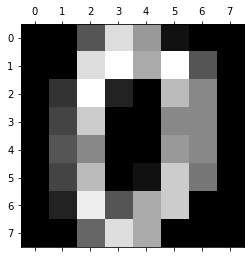

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [0]:
digits=load_digits()
X = digits.data
print("The shape of the digits dataset:") 
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

### 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [0]:
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

X[0,:] # Looking the new features after scaling

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

### 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [0]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

### 3) Setting up the output layer

### One hot encoding
Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

Thus we need to change our target so it is the same as our hoped for output of the neural network.  
-  If $y=0$ we change it into the vector $(1,0,0,0,0,0,0,0,0,0)$. 
-  If $y=1$ we change it into the vector $(0,1,0,0,0,0,0,0,0,0)$
-  etc

See page 29 from the website listed above

The code to covert the target vector.


In [0]:
print('/test/test_{:0>3f}'.format(np.around(9.7748848488448, decimals=4)))

/test/test_9.774900


In [0]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

Converting the training and test targets to vectors 

In [0]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

A quick check to see that our code performs as we expect 

In [0]:
print(y_train[0:4])
print(y_v_train[0:4])

[3 6 1 8]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


### 4) Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [0]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [0]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [0]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

### Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [0]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        # import pdb; pdb.set_trace()
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

### Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [0]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

### The Back Propagation Algorithm


In [0]:
def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

def train_nn(nn_structure, X_train, y_train, X_test, y_test, iter_num=100, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y_train)
    avg_cost_func = []

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []
    train_examples = len(y_train)
    test_examples = len(y_test)

    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Epoch {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0

        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0


        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X_train[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y_train[i,:], a[l], z[l])
                    loss_train += np.linalg.norm((y_train[i,:]-a[l]))
                    if np.argmax(a[len(nn_structure)]) == np.argmax(y_v_train[i]):
                      acc_train += 1.0
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        
        # Test model

        # get y prediction
        # y_pred = predict_y(W, b, X_test, 3)
        
        for i in range(test_examples):
         
            a, z = feed_forward(X_test[i, :], W, b)
            # calculate loss
            loss_test += np.linalg.norm((y_test[i,:]-a[len(nn_structure)]))
            # calculate accuracy
            if np.argmax(a[len(nn_structure)]) == np.argmax(y_v_test[i]):
                acc_test += 1
            
        # complete the average cost calculation
        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
        cnt += 1
    return W, b, (loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)




### Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [0]:
nn_structure = [64, 30, 10]
    
# train the NN
%time W, b, result_cnn_vanilla = train_nn(nn_structure, X_train, y_v_train, X_test, y_v_test, epochs, 0.25)

Starting gradient descent for 3000 iterations
Epoch 0 of 3000
Epoch 1000 of 3000
Epoch 2000 of 3000
CPU times: user 5min 36s, sys: 8.01 ms, total: 5min 36s
Wall time: 5min 36s


### Plotting the learning curve


In [0]:
def plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq):
    print('The test set prediction accuracy is {}%'.format(acc_test_seq[-1] * 100))
    # import pdb; pdb.set_trace()
    source = ColumnDataSource(data={
        'epoch'            : range(1, len(loss_test_seq) + 1),
        'train_loss'    : loss_train_seq,
        'test_loss'        :  loss_test_seq,
    })

    p = figure(title='Loss', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_loss', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_loss', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "top_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Loss' 

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Loss', '@train_loss{0.000 a}'),
                  ('Test Loss', '@test_loss{0.000 a}'),
        ],

        mode='mouse'
    ))

    show(p)

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_train_seq) + 1),
        'train_acc'    : np.array(acc_train_seq),
        'test_acc'        :  np.array(acc_test_seq),
    })

    p = figure(title='Accuracy', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_acc', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_acc', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "bottom_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy' 
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Accuracy', '@{train_acc}{%0.2f}'),
                  ('Test Accuracy', '@{test_acc}{%0.2f}'),
        ],

        mode='mouse'
    ))

    show(p)

In [0]:
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_cnn_vanilla

plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


The test set prediction accuracy is 88.45618915159945%


## Part A ( ii ) // Convolutional Neural Network Extension From Scratch On Dataset I


### Import Libraries

In [0]:
import numpy as np
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter
from bokeh.io import output_notebook
output_notebook()

### Creat CNN Class

In [0]:

class CNN:

    def __init__(self, num_kernels, pool_size, out_nodes, seed):
        self.kernels = self.Kernels(num_kernels)  # 8x8x1  to 6x6x10
        # self.pool = self.Pool(pool_size)  # 6x6x10 to 3x3x10
        self.sigmoid = self.Sigmoid(6 * 6 * num_kernels, out_nodes)  # 6x6x10 to 10
        np.random.seed(seed)

    class Kernels:
        # The set of kernels and kernel functions

        def __init__(self, num_kernels):
            self.num_kernels = num_kernels
            self.size_kernel = 3
            self.kernels = np.random.randn(num_kernels, 3, 3) / (self.size_kernel ** 2)

        def forward(self, x):
            self.cur_x = x

            height, width = x.shape
            result = np.zeros((height - 2, width - 2, self.num_kernels))

            for i in range(height-2):
                for j in range(width-2):
                    block = x[i:(i+3), j:(j+3)]
                    result[i,j] = np.sum(block * self.kernels, axis=(1, 2))
            return result

        def back(self, delta_cnn, alpha):
            height, width = self.cur_x.shape
            dk = np.zeros(self.kernels.shape)
            delta_cnn = delta_cnn.reshape(height-2, width-2,self.num_kernels)
            for i in range(height - 2):
                for j in range(width - 2):
                    block_x = self.cur_x[i:(i+3), j:(j+3)]
                    # block_delta = delta_cnn[i:(i+3), j:(j+3)]
                    for k in range(self.num_kernels):
                        dk[k] += delta_cnn[i,j,k] * block_x

            self.kernels += -alpha * dk


    class Pool:
        # use max pooling with size 2x2
        def __init__(self, pool_size):
            self.dim = pool_size  # size of the pool

        def forward(self, x):
            self.cur_input = x
            height, width, num_k = x.shape
            result = np.zeros((height // 2, width // 2, num_k))
            for i in range(height // 2):
                for j in range(width // 2):
                    block = x[(i*2):(i*2+2), (j*2):(j*2+2)]
                    result[i,j] = np.amax(block, axis=(0,1))
            return result

        def back(self, delta_pool):

            height, width, num_k = self.cur_input.shape
            delta_pool = delta_pool.reshape((height//2, width//2, num_k))
            delta_cnn = np.zeros((height, width, num_k))

            for i in range(height // 2):
                for j in range(width // 2):
                    block = self.cur_input[(i*2):(i*2+2),(j*2):(j*2+2)]
                    b_h, b_w, b_k = block.shape
                    maximum = np.amax(block, axis=(0,1))
                    for s in range(b_h):
                        for t in range(b_w):
                            for u in range(b_k):
                                if block[s, t, u] == maximum[u]:
                                    delta_cnn[i*2+s, j*2+t, u] = delta_pool[i,j,u]
            return delta_cnn


    class Sigmoid:
        # Use a fully connected layer using sigmoid activation

        def __init__(self, in_nodes, out_nodes):
            self.w = np.random.randn(out_nodes, in_nodes) / in_nodes
            self.b = np.zeros((out_nodes, 1))

        def sig(self,z):
            return 1 / (1+np.exp(-z))

        def d_sig(self,z):
            return self.sig(z) * (1-self.sig(z))

        def loss(self, y, yhat):
            self.y_vector = np.zeros((len(yhat), 1))
            self.y_vector[y, 0] = 1.0
            loss = np.linalg.norm(self.y_vector - yhat)
            accuracy = 1 if np.argmax(yhat[:, 0]) == y else 0
            return loss, accuracy

        def forward(self, x):
            # TODO forward pass
            self.z_cnn = x.reshape(-1, 1)
            self.a_cnn = self.sig(self.z_cnn)

            self.z_out = np.matmul(self.w, self.a_cnn) + self.b
            self.a_out = self.sig(self.z_out)

            return self.a_out

        def back(self, alpha):

            w_grad = np.zeros(self.w.shape)
            b_grad = np.zeros(self.b.shape)

            # get delta for out layer
            delta_out = -(self.y_vector - self.a_out) * self.d_sig(self.z_out)

            # get delta for hidden layer
            delta_pool = np.dot(self.w.T, delta_out) * self.d_sig(self.z_cnn)

            w_grad += -alpha * np.matmul(delta_out, self.a_cnn.T)
            b_grad += -alpha * delta_out
            # TODO back pass through pool and cnn layers
            return delta_pool


### Create utility functions 

In [0]:

def get_data():
    digits = load_digits()
    X = digits.data
    y = digits.target

    X_scale = StandardScaler()
    X = X_scale.fit_transform(digits.data)

    # Split the data into training and test set.  60% training and %40 test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    # Reshape X_train and X_test to be (-1, 8, 8)
    X_train = X_train.reshape((-1, 8, 8))
    X_test = X_test.reshape((-1, 8, 8))
    return (X_train, X_test, y_train, y_test)

def shuffle(X, y):
    new_order = np.random.permutation(len(y))
    X = X[new_order]
    y = y[new_order]
    return X, y

def forward(x, y, model):
    result = model.kernels.forward(x)
    # result = model.pool.forward(result)
    yhat = model.sigmoid.forward(result)
    loss, accuracy = model.sigmoid.loss(y, yhat)
    return yhat, loss, accuracy


def train(x, y, model, alpha=0.1):
    # forward
    _, loss, accuracy = forward(x, y, model)

    # back
    delta = model.sigmoid.back(alpha)
    # delta = model.pool.back(delta)
    model.kernels.back(delta, alpha)

    return loss, accuracy


def plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq):
    print('The test set prediction accuracy is {}%'.format(acc_test_seq[-1] * 100))
    source = ColumnDataSource(data={
        'epoch'            : range(1, len(loss_test_seq) + 1),
        'train_loss'    : loss_train_seq,
        'test_loss'        :  loss_test_seq,
    })

    p = figure(title='Loss', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_loss', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_loss', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "top_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Loss'

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Loss', '@train_loss{0.000 a}'),
                  ('Test Loss', '@test_loss{0.000 a}'),
        ],

        mode='mouse'
    ))

    show(p)

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_train_seq) + 1),
        'train_acc'    : np.array(acc_train_seq),
        'test_acc'        :  np.array(acc_test_seq),
    })

    p = figure(title='Accuracy', plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_acc', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_acc', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "bottom_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy'
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Accuracy', '@{train_acc}{%0.2f}'),
                  ('Test Accuracy', '@{test_acc}{%0.2f}'),
        ],

        mode='mouse'
    ))

    show(p)



### Train and Test CNN Model

In [0]:
kernel_layers = 64
pool_size = 2
epochs = epochs
out_nodes = 10
alpha = 0.4
seed = 34

def train_cnn(epochs, alpha, kernel_layers, pool_size, out_nodes, seed):

    X_train, X_test, y_train, y_test = get_data()

    model = CNN(kernel_layers, pool_size, out_nodes, seed)

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []
    train_examples = len(y_train)
    test_examples = len(y_test)

    print('=' * 30)
    print('==== Hyperparameters ====')
    print('='*30)
    print('Learning Rate: {}'.format(alpha))
    print('Kernel Layers: {}'.format(kernel_layers))
    # print('Pool Size: {}'.format(pool_size))
    print('Epochs: {}'.format(epochs))
    print('Seed: {}'.format(seed))
    print('=' * 30 + '\n')
    for epoch in range(epochs):

        if epoch != 0:
            print('Test Loss: {}\nTest Accuracy: {} %'.format(loss_test_seq[-1], acc_test_seq[-1]*100))
            print('Train Loss: {}\nTrain Accuracy: {} %\n\n'.format(loss_train_seq[-1], acc_train_seq[-1]*100))
        print('=' * 30)
        print('Starting epoch {} of {}'.format(epoch, epochs))
        X_train, y_train = shuffle(X_train, y_train)

        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0

        for i, (image, label) in enumerate(zip(X_train, y_train)):
            loss, acc = train(image, label, model, alpha)
            loss_train += loss
            acc_train += acc


        for i, (image, label) in enumerate(zip(X_test, y_test)):
            _, loss, acc = forward(image, label, model)
            loss_test += loss
            acc_test += acc


        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
    
    return loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq

%time result_cnn_scratch = train_cnn(epochs, alpha, kernel_layers, pool_size, out_nodes, seed)
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_cnn_scratch
plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)
print('Done!')


Streaming output truncated to the last 5000 lines.
Test Accuracy: 57.99721835883172 %
Train Loss: 1.5733733988931233
Train Accuracy: 62.430426716141 %


Starting epoch 1356 of 3000
Test Loss: 1.5739213781485188
Test Accuracy: 57.99721835883172 %
Train Loss: 1.5733726588348662
Train Accuracy: 62.430426716141 %


Starting epoch 1357 of 3000
Test Loss: 1.5739206615927406
Test Accuracy: 57.99721835883172 %
Train Loss: 1.573371918591445
Train Accuracy: 62.430426716141 %


Starting epoch 1358 of 3000
Test Loss: 1.5739199459354658
Test Accuracy: 57.99721835883172 %
Train Loss: 1.573371178396449
Train Accuracy: 62.430426716141 %


Starting epoch 1359 of 3000
Test Loss: 1.5739192313357258
Test Accuracy: 57.99721835883172 %
Train Loss: 1.5733704399998918
Train Accuracy: 62.430426716141 %


Starting epoch 1360 of 3000
Test Loss: 1.573918518031477
Test Accuracy: 57.99721835883172 %
Train Loss: 1.5733697027201616
Train Accuracy: 62.430426716141 %


Starting epoch 1361 of 3000
Test Loss: 1.573917804

## Part A ( iii ) Compare Results on Dataset I

In [0]:


def plot_results_compare(result_cnn_vanilla, result_cnn_pytorch, result_cnn_scratch):
    
    loss_train_van, loss_test_van, acc_train_van, acc_test_van = result_cnn_vanilla
    loss_train_torch, loss_test_torch, acc_train_torch, acc_test_torch = result_cnn_pytorch
    loss_train_scratch, loss_test_scratch, acc_train_scratch, acc_test_scratch  = result_cnn_scratch

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_test_scratch) + 1),
        'test_acc_van'        :  np.array(acc_test_van),
        # 'test_acc_torch'        :  np.array(acc_test_torch),
        'test_acc_scratch'        :  np.array(acc_test_scratch),
    })

    p = figure(title='Accuracy', plot_width=600, plot_height=400)

    l_van = p.line(x='epoch', y='test_acc_van', color='#329fe3', line_alpha=0.8 , line_width=2, source=source)
    # l_torch = p.line(x='epoch', y='test_acc_torch', color='#e33270', line_alpha=0.8, line_width=2, source=source)
    l_scratch = p.line(x='epoch', y='test_acc_scratch', color='#e33000', line_alpha=0.8, line_width=2, source=source)
    
    # p.legend.location = "center_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy'
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')
    

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('No CNN', '@{test_acc_van}{%0.2f}'),
                  ('Custom CNN', '@{test_acc_scratch}{%0.2f}'),
                  # ('PyTorch CNN', '@{test_acc_torch}{%0.2f}'),
        ],

        mode='mouse'
    ))

    legend = Legend(items=[('No CNN', [l_van]), ('Custom CNN', [l_scratch]),], location=(0,250))
    p.add_layout(legend, 'left')

    show(p)

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_test_scratch) + 1),
        'test_acc_van'        :  np.array(acc_test_van),
        'test_acc_torch'        :  np.array(acc_test_torch),
        # 'test_acc_scratch'        :  np.array(acc_test_scratch),
    })

    p = figure(title='Accuracy', plot_width=600, plot_height=400)

    l_van = p.line(x='epoch', y='test_acc_van', color='#329fe3', line_alpha=0.8 , line_width=2, source=source)
    l_torch = p.line(x='epoch', y='test_acc_torch', color='#e33270', line_alpha=0.8, line_width=2, source=source)
    # l_scratch = p.line(x='epoch', y='test_acc_scratch', color='#e33000', line_alpha=0.8, line_width=2, source=source)
    # p.legend.location = "center_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy'
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')
    

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('No CNN', '@{test_acc_van}{%0.2f}'),
                  # ('Custom CNN', '@{test_acc_scratch}{%0.2f}'),
                  ('PyTorch CNN', '@{test_acc_torch}{%0.2f}'),
        ],

        mode='mouse'
    ))

    legend = Legend(items=[('No CNN', [l_van]), ('PyTorch CNN', [l_torch]),], location=(0,250))
    p.add_layout(legend, 'left')

    show(p)

In [0]:
plot_results_compare(result_cnn_vanilla, result_cnn_pytorch, result_cnn_scratch)









## Part B ( i ) Naive Algorithm on Dataset II

## Part B ( ii ) Extended Algorithm using CNN on Dataset II

## Part B ( iii ) Compare Results on Dataset II